#### <center> As a first postprocessing tool this notebook just visualize S2S forecasts for a specific date 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import tqdm
from utils import *
import matplotlib.dates as mdates

In [9]:
s2s_anom  = xr.open_dataset('data/HOVMOLLERS/CLIMATOLOGICAL_ANOMALIES/S2S_tropical-coastsouth_anomaly.nc', decode_timedelta=False)
s2s_ianom = xr.open_dataset('data/HOVMOLLERS/INTRASEASONAL_ANOMALIES/S2S_tropical-coastsouth_isanomaly.nc', decode_timedelta=False)

glorys_anom  = xr.open_dataset('data/HOVMOLLERS/CLIMATOLOGICAL_ANOMALIES/GLORYS_tropical-coastsouth_anomaly.nc')
glorys_ianom = xr.open_dataset('data/HOVMOLLERS/INTRASEASONAL_ANOMALIES/GLORYS_tropical-coastsouth_isanomaly.nc')

altim_anom  = xr.open_dataset('data/HOVMOLLERS/CLIMATOLOGICAL_ANOMALIES/SEALEVEL_tropical-coastsouth_anomaly.nc')
altim_ianom = xr.open_dataset('data/HOVMOLLERS/INTRASEASONAL_ANOMALIES/SEALEVEL_tropical-coastsouth_isanomaly.nc')


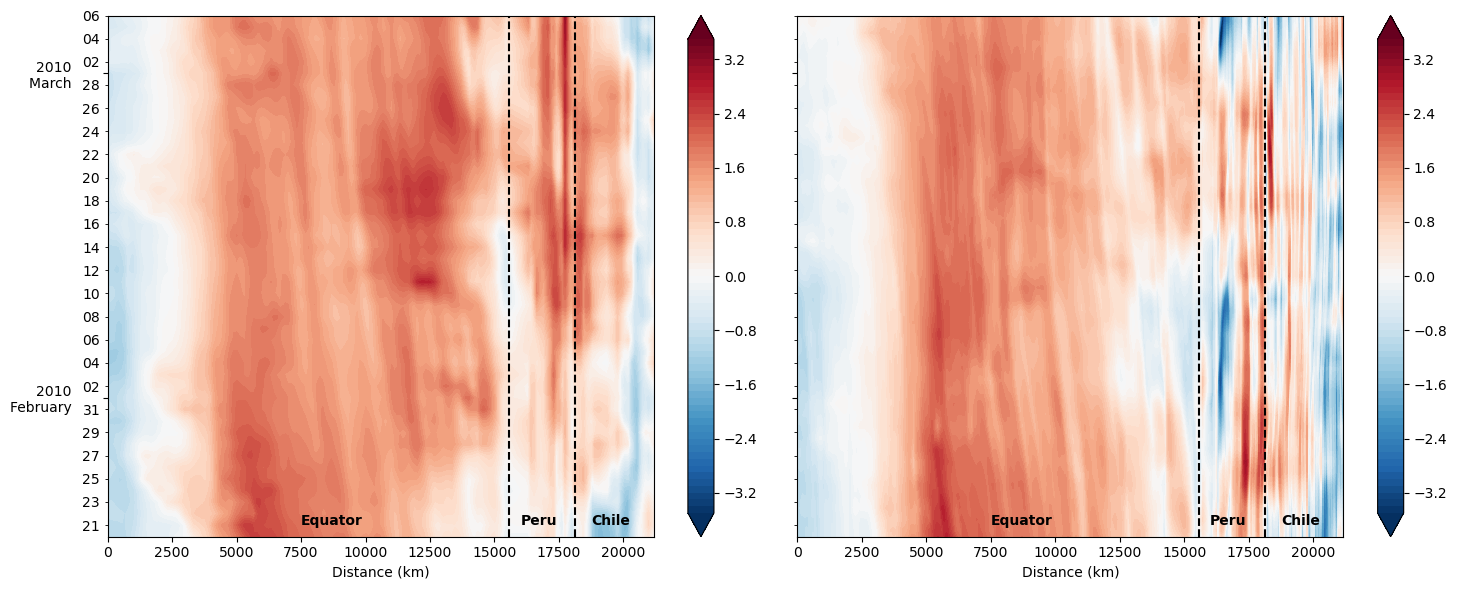

In [12]:
# ---------------------------- forecast comparison --------------------------- #
fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=100, facecolor='w',
                       sharey=True, sharex=True)
target_date        = '2010-01-20'
member             = 0
# vmin,vmax,step     = -10/100,10/100,0.1/100
vmin,vmax,step     = -3.5,3.5,0.1
smooth,wavenumber  = False,50
intraseasonal_anom = False
variable           = 'sst'
# ---------------------------------------------------------------------------- #
if intraseasonal_anom:
    forecast  = s2s_ianom[variable].sel(member=member, inittime=target_date)
    forecast.coords['leadtime'] = [pd.to_datetime(target_date)+
                                pd.Timedelta(days=lead.item())
                                for lead in forecast.leadtime]
    reference = glorys_ianom[variable].sel(time=slice(pd.to_datetime(target_date)-pd.Timedelta(days=1),
                                            pd.to_datetime(target_date)+
                                            pd.Timedelta(days=46)))
else:
    forecast  = s2s_anom[variable].sel(member=member, inittime=target_date)
    forecast.coords['leadtime'] = [pd.to_datetime(target_date)+
                                pd.Timedelta(days=lead.item())
                                for lead in forecast.leadtime]
    reference = glorys_anom[variable].sel(time=slice(pd.to_datetime(target_date)-pd.Timedelta(days=1),
                                            pd.to_datetime(target_date)+
                                            pd.Timedelta(days=46)))
if smooth:
    forecast  = filter_xarray(forecast, 'distance', 5, 2*np.pi/wavenumber)
    reference = filter_xarray(reference, 'distance', 5, 2*np.pi/wavenumber)

# ----------------------------------- plot ----------------------------------- #
forecast.plot.contourf(ax=ax[0], levels=np.arange(vmin,vmax+step,step),
                       cmap='RdBu_r', extend='both', cbar_kwargs={'label':""})
reference.plot.contourf(ax=ax[1], levels=np.arange(vmin,vmax+step,step),
                        cmap='RdBu_r', extend='both', cbar_kwargs={'label':""})

for axis in ax.ravel():
    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.set_title('')
    axis.yaxis.set_major_formatter(mdates.DateFormatter('%Y      \n%B      '))
    axis.yaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axis.yaxis.set_minor_locator(mdates.DayLocator(interval=2))
    axis.yaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    axis.axvline(forecast.isel(distance=-39).distance, color='k', ls="--")
    axis.axvline(forecast.isel(distance=-23).distance, color='k', ls="--")
    axis.text(7500,pd.to_datetime(target_date)+pd.Timedelta(days=1),
              'Equator', transform=axis.transData, weight='bold')
    axis.text(16000,pd.to_datetime(target_date)+pd.Timedelta(days=1),
              'Peru', transform=axis.transData, weight='bold')
    axis.text(18750,pd.to_datetime(target_date)+pd.Timedelta(days=1),
              'Chile', transform=axis.transData, weight='bold')
    axis.set_ylim(pd.to_datetime(target_date),pd.to_datetime(target_date)+pd.Timedelta(days=45))
    axis.set_xlim(0, min(forecast.distance.isel(distance=-1), reference.distance.isel(distance=-1)))
    axis.set_xlabel('Distance (km)')
fig.tight_layout()